In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
from pycocotools import coco
from pprint import pprint

BATCH_SIZE = 4
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"
AUTOTUNE = tf.data.AUTOTUNE

train_annotations = "label_kaggle_training/result.json"
train_images = "label_kaggle_training/images"
coco_train = coco.COCO(train_annotations)

val_annotations = "label_kaggle_test/result.json"
val_images = "label_kaggle_test/images"
coco_val = coco.COCO(val_annotations)

categories = coco_train.loadCats(coco_train.getCatIds())
class_map = {category['id']: category['name'] for category in categories}

pprint(class_map)

2024-04-26 22:04:34.204676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dino/miniconda3/envs/picar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{0: 'box',
 1: 'green_light',
 2: 'left_arrow',
 3: 'no_light',
 4: 'person',
 5: 'red_light',
 6: 'right_arrow',
 7: 'tree',
 8: 'unknown_arrow'}


In [2]:
def getAnnotations(coco_instance, image_id):
    ann_ids = coco_instance.getAnnIds(imgIds=[image_id])
    anns = coco_instance.loadAnns(ann_ids)
    
    bboxes = []
    category_ids = []
    
    for ann in anns:
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        
        bboxes.append(bbox)
        category_ids.append(category_id)
    
    return {'boxes': bboxes, 'classes': category_ids}
        
def loadImage(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, IMAGE_SIZE) # Screws up bounding boxes, we'll add it as a preprocessing layer
    image = tf.cast(image, tf.float32)
    return image

def loadDatapaths(coco_instance, image_dir):
    img_ids = coco_instance.getImgIds()
    img_paths = []
    boxes = []
    classes = []
    
    for img_id in img_ids:
        img = coco_instance.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img["file_name"])
        
        annotations = getAnnotations(coco_instance, img_id)
        
        if len(annotations["boxes"]) > 0 and len(annotations["classes"]) > 0:
            img_paths.append(img_path)
            boxes.append(annotations["boxes"])
            classes.append(annotations["classes"])
        
    return img_paths, boxes, classes

def loadDatapoint(img_path, boxes, classes):
    image = loadImage(img_path)
    bbox = {"boxes": boxes, "classes": classes}
    return {"images": image, "bounding_boxes": bbox}

def loadDataset(coco_instance, image_dir):
    img_paths, boxes, classes = loadDatapaths(coco_instance, image_dir)
    img_paths = tf.ragged.constant(img_paths)
    boxes = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(classes)
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, boxes, classes))
    dataset = dataset.map(loadDatapoint, num_parallel_calls=AUTOTUNE)
    dataset = dataset.ragged_batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.shuffle(8 * BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [3]:
train_dataset = loadDataset(coco_train, train_images)
val_dataset = loadDataset(coco_val, val_images)

2024-04-26 22:04:39.363577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:04:39.493732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:04:39.493965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:04:39.495581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:04:39.495768: I external/local_xla/xla/stream_executor

In [4]:
def visualiseDataset(inputs, value_range=(0, 255), rows=2, cols=2, bounding_box_format=BBOX_FORMAT):
    inputs = next(iter(inputs.take(1)))
    images = inputs["images"]
    bounding_boxes = inputs["bounding_boxes"]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_map
    )

Number of training batches: 1218


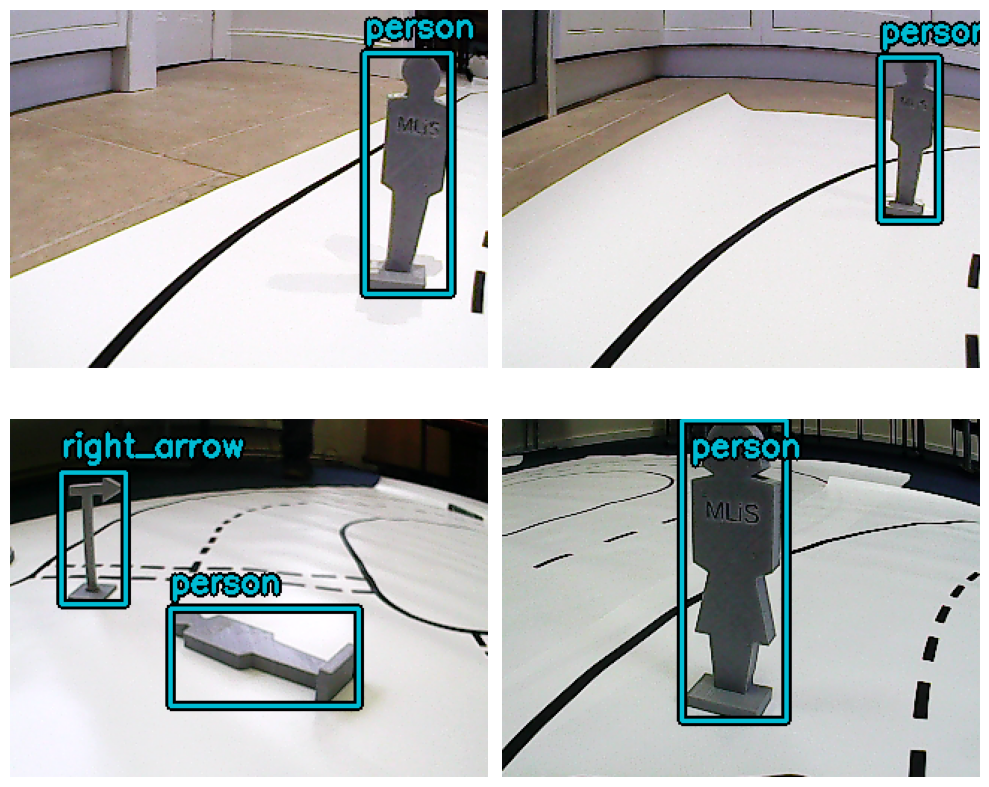

In [5]:
print("Number of training batches: {}".format(len(train_dataset)))
visualiseDataset(train_dataset)

2024-04-26 22:04:43.644122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node rand_augment_1_map_while_cond_false_1066}}{{node rand_augment_1/map/while/cond/random_choice_1/stateful_uniform/RngReadAndSkip}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-26 22:04:43.644189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node rand_augment_1_map_while_cond_false_1066}}{{node rand_augment_1/map/while/cond/random_choice_1/stateful_uniform/RngReadAndSkip}}]]
	 [[rand_augment_1/map/while/body/_1/rand_augment_1/map/while/cond_1/pivot_f/_66/_43]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-26 22:04:43.644209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17560858112534413845
2024-04-26 22:04:43.644223: I tensorflow/core

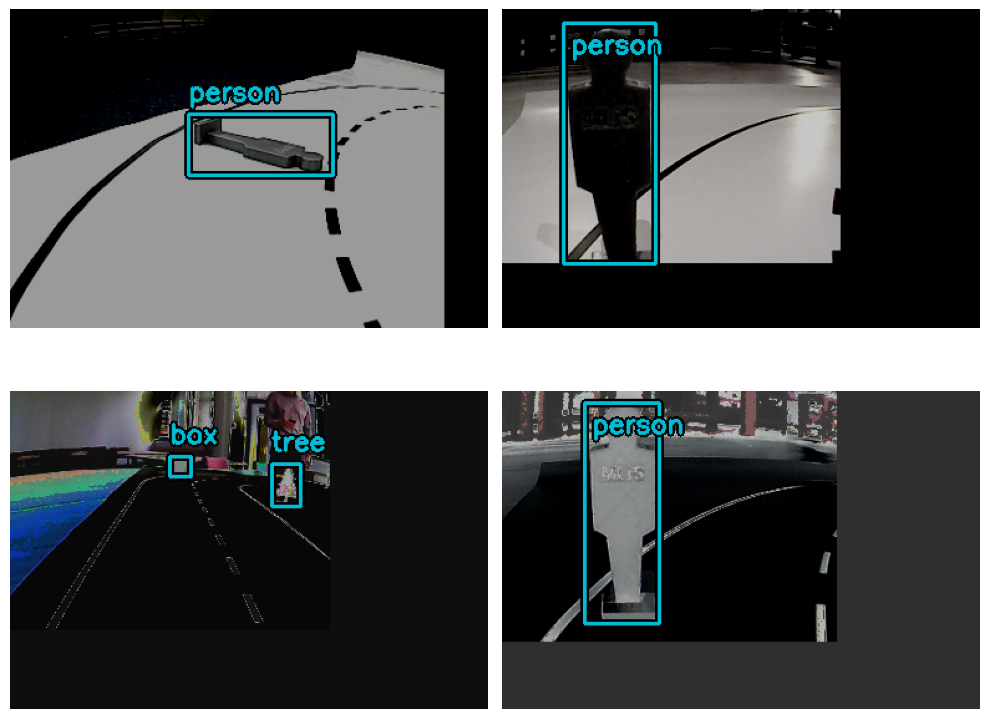

In [6]:
# TODO: Try MixUp
bbox_augmenters = [
    keras_cv.layers.JitteredResize(
        target_size=IMAGE_SIZE,
        scale_factor=(0.75, 1.3),
        bounding_box_format=BBOX_FORMAT
    )
]

image_augmenters = [
    keras_cv.layers.RandAugment(
        value_range=(0, 255),
        geometric=False
    )
]

def createAugmenterFunction(augmenters):
    def augmenterFunction(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenterFunction

bbox_augmenter = createAugmenterFunction(bbox_augmenters)
image_augmenter = createAugmenterFunction(image_augmenters)

train_dataset = train_dataset.map(bbox_augmenter, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(lambda x: {"images": image_augmenter(x["images"]), "bounding_boxes": x["bounding_boxes"]}, num_parallel_calls=AUTOTUNE)

visualiseDataset(train_dataset)


In [7]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True
)


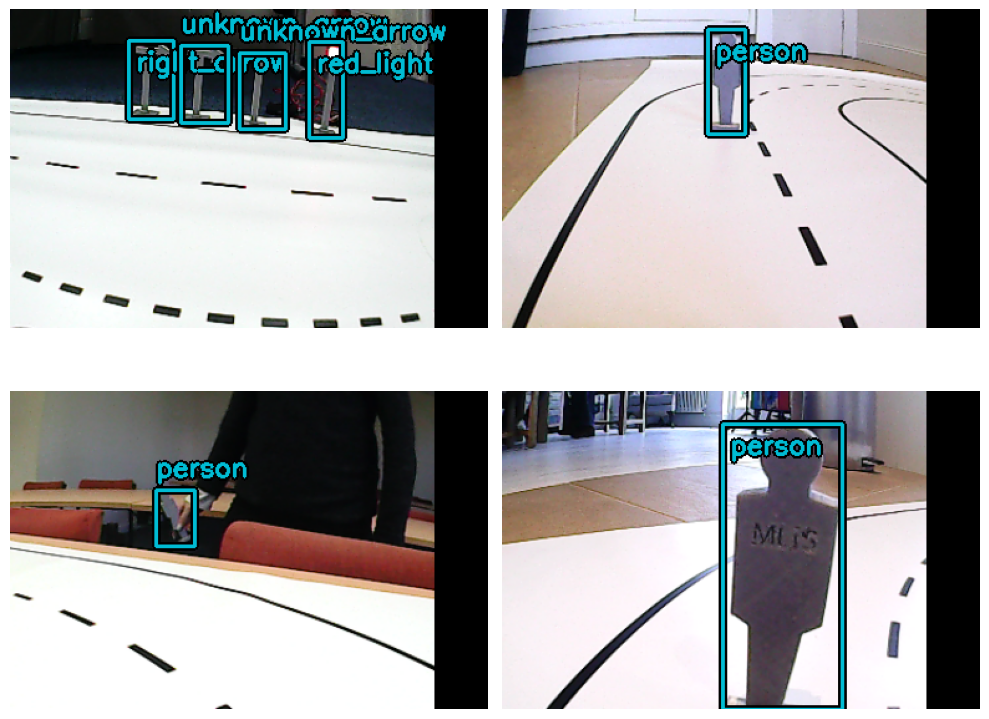

In [8]:

val_dataset = val_dataset.map(validation_resizing, num_parallel_calls=AUTOTUNE)

visualiseDataset(val_dataset)

In [9]:
# To be TPU compatible, bounding box tensors must be Dense, not Ragged
def dictToTuple(inputs):
    return (inputs["images"], 
            keras_cv.bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32))

train_dataset = train_dataset.map(dictToTuple, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(dictToTuple, num_parallel_calls=AUTOTUNE)

In [10]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_s_backbone_coco",
    bounding_box_format=BBOX_FORMAT,
    num_classes=len(class_map)
)

In [11]:
# TODO: Hand-make a PiecewiseConstantDecay schedule
base_lr = 0.005
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr,
    momentum=0.9,
    global_clipnorm=10.0
)

In [12]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer
)

In [13]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    validation_data=val_dataset,
    bounding_box_format=BBOX_FORMAT,
)

In [14]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[coco_metrics_callback]
)

Epoch 1/40


I0000 00:00:1714165504.680299    2896 service.cc:145] XLA service 0x7f47d4003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714165504.680402    2896 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-04-26 22:05:05.551755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 22:05:06.971818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1714165533.402046    2896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Av

2024-04-26 22:06:58.485165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Ave

2024-04-26 22:08:10.738961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Ave

2024-04-26 22:09:22.766398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Ave

2024-04-26 22:10:36.656682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  33/1218 ━━━━━━━━━━━━━━━━━━━━ 1:07 57ms/step - loss: 2.0095

KeyboardInterrupt: 

In [ ]:
model.save("keras_cv_yolov8.keras")

In [ ]:
model2 = keras.models.load_model("keras_cv_yolov8.keras", custom_objects={"YOLOV8Detector": keras_cv.models.YOLOV8Detector})

/home/dino/miniconda3/envs/picar/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [ ]:
model.evaluate(val_dataset)

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9752


1.9188868999481201

In [ ]:
model2.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer
)

#model2.evaluate(val_dataset)

In [ ]:
model2.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.6
)

In [ ]:
image = tf.io.read_file("label_kaggle_test/images/0e87d07d-192.png")
image = np.array(tf.image.decode_jpeg(image, channels=3))
image = validation_resizing([image])


y_pred = model2.predict(image)

keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_map
)


AttributeError: module 'keras_cv.src.backend.keras' has no attribute 'src'